# Классификация: превышает ли значение  SI медианное значение выборки

In [1]:
!pip install -q catboost
!pip install -q optuna
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, f1_score, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 21.7 MB/s eta 0:00:00


In [2]:
# Загрузка данных через диалоговое окно
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('selected_features_SI.csv')

Saving selected_features_SI.csv to selected_features_SI.csv


In [3]:
df.head()

,BalabanJ,MinAbsEStateIndex,BCUT2D_LOGPHI,SMR_VSA5,VSA_EState4,MinPartialCharge,EState_VSA2,BCUT2D_LOGPLOW,MinAbsPartialCharge,Kappa3,...,MolLogP,fr_C_O,FractionCSP3,SMR_VSA7,FpDensityMorgan1,SlogP_VSA4,NumSaturatedHeterocycles,fr_Al_COO,SlogP_VSA10,SI
0,1.164038,0.387225,2.644698,105.750639,4.807589,-0.293526,0.000000,-2.322229,0.038844,2.868737,...,7.1212,0,0.923077,0.00000,0.642857,33.495774,0,0,0.000000,28.125000
1,1.080362,0.533868,2.658342,117.834321,2.153503,-0.313407,0.000000,-2.444817,0.012887,3.027177,...,6.1556,0,1.000000,0.00000,0.607143,33.495774,0,0,0.000000,7.000000
2,1.219066,0.543231,2.679014,117.834321,2.184127,-0.325573,0.000000,-2.565224,0.094802,3.470070,...,7.1292,0,1.000000,0.00000,0.562500,33.495774,0,0,0.000000,0.720000
3,1.120513,0.390603,2.644709,112.171461,4.827852,-0.293526,0.000000,-2.322030,0.038844,3.263848,...,7.5113,0,0.925926,0.00000,0.620690,33.495774,0,0,0.000000,63.235294
4,1.136678,0.270476,2.648473,86.488175,9.071783,-0.257239,10.829981,-2.318893,0.062897,3.345855,...,9.1148,0,0.575758,59.65784,0.600000,33.495774,0,0,11.374773,1.300000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BalabanJ                  998 non-null    float64
 1   MinAbsEStateIndex         998 non-null    float64
 2   BCUT2D_LOGPHI             998 non-null    float64
 3   SMR_VSA5                  998 non-null    float64
 4   VSA_EState4               998 non-null    float64
 5   MinPartialCharge          998 non-null    float64
 6   EState_VSA2               998 non-null    float64
 7   BCUT2D_LOGPLOW            998 non-null    float64
 8   MinAbsPartialCharge       998 non-null    float64
 9   Kappa3                    998 non-null    float64
 10  SlogP_VSA3                998 non-null    float64
 11  AvgIpc                    998 non-null    float64
 12  Chi3n                     998 non-null    float64
 13  RingCount                 998 non-null    int64  
 14  BertzCT   

In [5]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BalabanJ                  998 non-null    float64
 1   MinAbsEStateIndex         998 non-null    float64
 2   BCUT2D_LOGPHI             998 non-null    float64
 3   SMR_VSA5                  998 non-null    float64
 4   VSA_EState4               998 non-null    float64
 5   MinPartialCharge          998 non-null    float64
 6   EState_VSA2               998 non-null    float64
 7   BCUT2D_LOGPLOW            998 non-null    float64
 8   MinAbsPartialCharge       998 non-null    float64
 9   Kappa3                    998 non-null    float64
 10  SlogP_VSA3                998 non-null    float64
 11  AvgIpc                    998 non-null    float64
 12  Chi3n                     998 non-null    float64
 13  RingCount                 998 non-null    int64  
 14  BertzCT   

In [7]:
X = df.drop(['SI'], axis=1)
y_continuous = df['SI']
print(f"Размерность данных: {X.shape}")
print(f"Признаки: {list(X.columns)}")

Размерность данных: (998, 25)
Признаки: ['BalabanJ', 'MinAbsEStateIndex', 'BCUT2D_LOGPHI', 'SMR_VSA5', 'VSA_EState4', 'MinPartialCharge', 'EState_VSA2', 'BCUT2D_LOGPLOW', 'MinAbsPartialCharge', 'Kappa3', 'SlogP_VSA3', 'AvgIpc', 'Chi3n', 'RingCount', 'BertzCT', 'NHOHCount', 'MolLogP', 'fr_C_O', 'FractionCSP3', 'SMR_VSA7', 'FpDensityMorgan1', 'SlogP_VSA4', 'NumSaturatedHeterocycles', 'fr_Al_COO', 'SlogP_VSA10']


In [8]:
X_train, X_test, y_train_cont, y_test_cont = train_test_split(
    X, y_continuous,
    test_size=0.2,
    random_state=42
)

print(f"Train: {X_train.shape[0]} образцов")
print(f"Test: {X_test.shape[0]} образцов")

Train: 798 образцов
Test: 200 образцов


In [9]:
# считаем медиану
median_SI = y_train_cont.median()
print(f"Медиана IC50 (на train): {median_SI:.4f} mM")

y_train = (y_train_cont > median_SI).astype(int)
y_test = (y_test_cont > median_SI).astype(int)

# Распределение классов
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()
print(f"\nРаспределение классов в TRAIN:")
print(f"СC50 <= медианы (0): {train_counts[0]} ({train_counts[0]/len(y_train)*100:.1f}%)")
print(f"СC50 > медианы (1): {train_counts[1]} ({train_counts[1]/len(y_train)*100:.1f}%)")

print(f"\nРаспределение классов в TEST:")
print(f"СC50 <= медианы (0): {test_counts[0]} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f"СC50 > медианы (1): {test_counts[1]} ({test_counts[1]/len(y_test)*100:.1f}%)")

Медиана IC50 (на train): 3.8564 mM

Распределение классов в TRAIN:
СC50 <= медианы (0): 399 (50.0%)
СC50 > медианы (1): 399 (50.0%)

Распределение классов в TEST:
СC50 <= медианы (0): 100 (50.0%)
СC50 > медианы (1): 100 (50.0%)


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучение моделей

In [11]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Extra Trees': ExtraTreesClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss'),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}

results = {}
for name, model in models.items():
    print(f"\n--- Обучение {name} ---")

    # Выбираем данные (масштабированные для линейных моделей и SVM)
    if name in ['Logistic Regression', 'SVM']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    # Обучение модели
    model.fit(X_train_use, y_train)

    # Предсказания
    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]

    # Кросс-валидация на train
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='roc_auc')

    # Метрики на test
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Сохранение результатов
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



--- Обучение Logistic Regression ---
Accuracy: 0.6200
F1-score: 0.6082
ROC AUC: 0.6693
CV ROC AUC: 0.6578 ± 0.0272

--- Обучение Random Forest ---
Accuracy: 0.6900
F1-score: 0.6869
ROC AUC: 0.7070
CV ROC AUC: 0.7096 ± 0.0254

--- Обучение Extra Trees ---
Accuracy: 0.6850
F1-score: 0.6834
ROC AUC: 0.7079
CV ROC AUC: 0.6958 ± 0.0311

--- Обучение Gradient Boosting ---
Accuracy: 0.6800
F1-score: 0.6559
ROC AUC: 0.6970
CV ROC AUC: 0.6914 ± 0.0196

--- Обучение XGBoost ---
Accuracy: 0.6550
F1-score: 0.6425
ROC AUC: 0.7079
CV ROC AUC: 0.6959 ± 0.0197

--- Обучение SVM ---
Accuracy: 0.6500
F1-score: 0.6277
ROC AUC: 0.7194
CV ROC AUC: 0.7158 ± 0.0184

--- Обучение Naive Bayes ---
Accuracy: 0.6250
F1-score: 0.6114
ROC AUC: 0.6121
CV ROC AUC: 0.6334 ± 0.0168


Сравнение моделей

In [12]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'F1-Score': [results[name]['f1_score'] for name in results.keys()],
    'ROC AUC': [results[name]['roc_auc'] for name in results.keys()],
    'CV ROC AUC': [results[name]['cv_mean'] for name in results.keys()],
    'CV Std': [results[name]['cv_std'] for name in results.keys()]
})
best_idx = results_df['ROC AUC'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_model = results[best_model_name]

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   ROC AUC: {best_model['roc_auc']:.4f}")
print(f"   Accuracy: {best_model['accuracy']:.4f}")
print(f"   F1-Score: {best_model['f1_score']:.4f}")


ЛУЧШАЯ МОДЕЛЬ: SVM
   ROC AUC: 0.7194
   Accuracy: 0.6500
   F1-Score: 0.6277


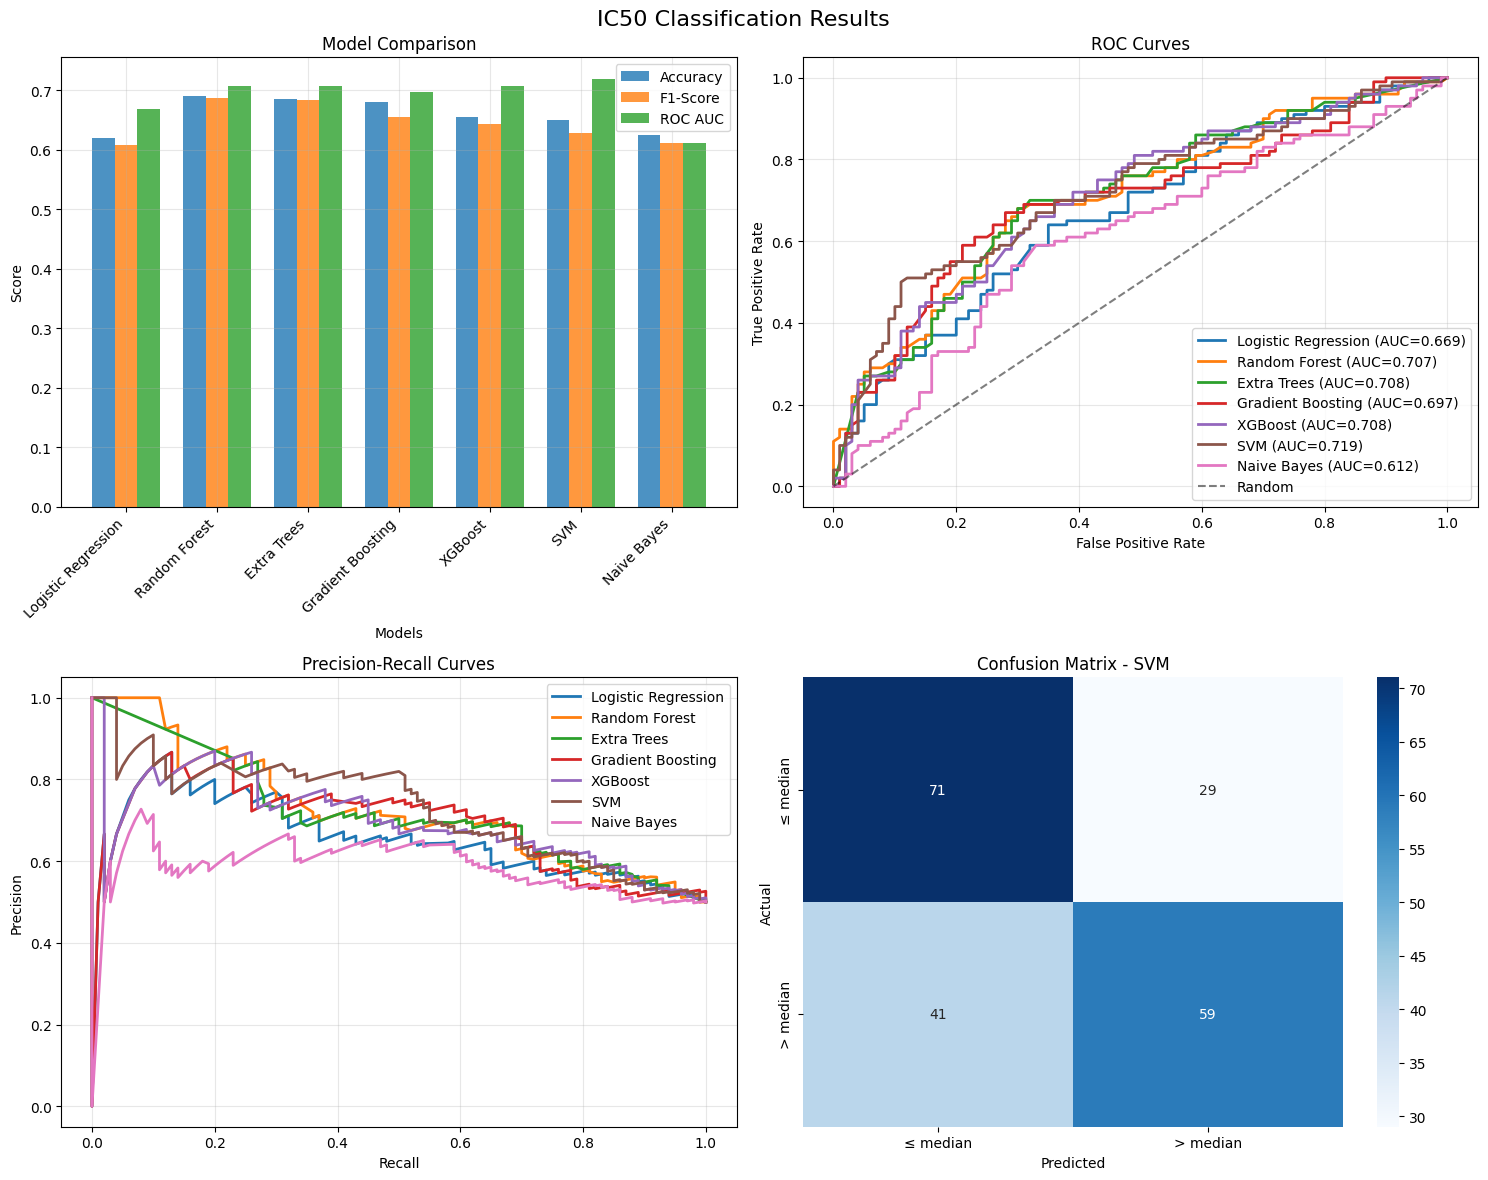

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('IC50 Classification Results', fontsize=16)

# 1. Сравнение моделей
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df))
width = 0.25

ax1.bar(x_pos - width, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax1.bar(x_pos, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)
ax1.bar(x_pos + width, results_df['ROC AUC'], width, label='ROC AUC', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ROC кривые
ax2 = axes[0, 1]
for name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
    auc_score = results[name]['roc_auc']
    ax2.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})", linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall кривые
ax3 = axes[1, 0]
for name in results.keys():
    precision, recall, _ = precision_recall_curve(y_test, results[name]['y_pred_proba'])
    ax3.plot(recall, precision, label=name, linewidth=2)

ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curves')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix лучшей модели
ax4 = axes[1, 1]
cm = confusion_matrix(y_test, best_model['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['≤ median', '> median'],
            yticklabels=['≤ median', '> median'])
ax4.set_title(f'Confusion Matrix - {best_model_name}')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.show()

#МОДЕЛЬ: SVM

71 - True Negatives (правильно предсказан класс "≤ median")

29 - False Positives (ошибочно предсказан как "> median")

41 - False Negatives (ошибочно предсказан как "≤ median")

59 - True Positives (правильно предсказан класс "> median")

Accuracy = (71 + 59) / (71 + 29 + 41 + 59) = 130/200 = 65%

Класс "≤ median": 71/(71+41) = 63.4% - средне

Класс "> median": 59/(29+59) = 67.0% - средне

Полнота (Recall):

Класс "≤ median": 71/(71+29) = 71.0% - хорошо

Класс "> median": 59/(41+59) = 59.0% - средне

Точность разделения на классы 65% точность

Допущено 29 ложных срабатываний - соединения с IC50 ≤ медианы модель считает активными, и 41 пропуск - активные соединения (> медианы) модель считает неактивными.

Т.е. мы ложно отбираем 29 соединений  и упускаем 41 потенциально активных


In [14]:
comparison_data = []
true_0, true_1 = sum(y_test == 0), sum(y_test == 1)

for name in results.keys():
    y_pred = results[name]['y_pred']
    pred_0, pred_1 = sum(y_pred == 0), sum(y_pred == 1)
    correct = sum(y_test == y_pred)

    comparison_data.append({
        'Model': name,
        'True_Class_0 (≤ медианы)': true_0,
        'True_Class_1 (> медианы)': true_1,
        'Pred_Class_0 (≤ медианы)': pred_0,
        'Pred_Class_1 (> медианы)': pred_1,
        'Correct': correct,
        'Total': len(y_test),
        'Accuracy': correct/len(y_test)
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nСводная таблица предсказаний:")
print(comparison_df.to_string(index=False))


Сводная таблица предсказаний:
              Model  True_Class_0 (≤ медианы)  True_Class_1 (> медианы)  Pred_Class_0 (≤ медианы)  Pred_Class_1 (> медианы)  Correct  Total  Accuracy
Logistic Regression                       100                       100                       106                        94      124    200     0.620
      Random Forest                       100                       100                       102                        98      138    200     0.690
        Extra Trees                       100                       100                       101                        99      137    200     0.685
  Gradient Boosting                       100                       100                       114                        86      136    200     0.680
            XGBoost                       100                       100                       107                        93      131    200     0.655
                SVM                       100                       1